In [1]:
# import packages
import cv2 as cv
import numpy as np
from typing import Optional, List
from timeit import default_timer as timer
from numba import cuda
import math
import matplotlib.pyplot as plt

# logging init
import logging

**CUDA Optimizations for Computer Vision Optimization**
---

To integrate CUDA Optimizations inside our sobel filtering algorithm (see computer-vision/algorithms/sobel_filter.ipynb for notes on the algorithm) we need to specify two functions:

  - A function that performs the windowed operation that we need to do, this should be an in place algorithm so we can alloc and dealloc effectively.
  - A wrapper function that calls ^. Inside this function we alloc and dealloc our inputs and outputs, define window sizes, and call the CUDA function.

**CUDA FUNCTION**

In [2]:
@cuda.jit # Tell numba jit compiler it needs to map cpu functions to cuda functions
def sobel_filter(input_image, output_image):
    # Apply sobel filter inplace on the output image.
    x, y = cuda.grid(2)

    if x < input_image.shape[0] - 2 and y < input_image.shape[1] - 2:
        # get Gx
        Gx = (
            input_image[x, y]
            - input_image[x + 2, y]
            + 2 * input_image[x, y + 1]
            - 2 * input_image[x + 2, y + 1]
            + input_image[x, y + 2]
            - input_image[x + 2, y + 2]
        )
        # get Gy
        Gy = (
            input_image[x, y]
            - input_image[x, y + 2]
            + 2 * input_image[x + 1, y]
            - 2 * input_image[x + 1, y + 2]
            + input_image[x + 2, y]
            - input_image[x + 2, y + 2]
        )

        # in place op
        output_image[x + 1, y + 1] = math.sqrt(Gx**2 + Gy**2)

**Notes:**

  - This function performs an in place operation on our output image array, meaning it changes the values stored inside of output_image instead of returning a copy.
  - Line 4: Define the number of dimensions we need to operate over, here we have a binary image, so we only have 2: X, Y.
  - Line 8: Get x direction colour grad
  - Line 17: Get y direction colour grad
  - Line 27: Merge and set value inside output image.

**Wrapper Function**

In [13]:
def cuda_sobel(np_image: np.ndarray, kernel_size: Optional[int]=16, variance_scaler: Optional[int]=4):
    np_image = cv.GaussianBlur(np_image, (kernel_size,kernel_size), np.std(np_image)/variance_scaler)
    # alloc
    cuda_im = cuda.to_device(np_image)
    output_image_ = np.zeros_like(np_image)
    threads_per_block = (kernel_size, kernel_size)

    # calculate dims
    blockspergrid_x = (
        np_image.shape[0] + threads_per_block[0] - 1
    ) // threads_per_block[0]
    blockspergrid_y = (
        np_image.shape[1] + threads_per_block[1] - 1
    ) // threads_per_block[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # apply sobel filter
    sobel_filter[blockspergrid, threads_per_block](cuda_im, output_image_)
    return output_image_

**Notes:**
  - Line 3: Send our input image to the GPU
  - Line 8-13: Define the number of threads we will need for each dim of our defined grid.
  - Line 14: Define total bounds for all dims
  - Line 18: Copy output_image back to the cpu

**Speed Testing**
---

**Setup + Load and Convert Image**

In [4]:
from resources import sobel_filter_cpu
im1 = cv.imread(f"./image1.jpg")
    # convert to grayscale
gim1 = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)

**CPU Sobel Filter**

Horizontal Range: (0.0, 1.0)
Vertical Range: (0.0, 1.0)
Calculating Sobel Filter on CPU took: 251.66s


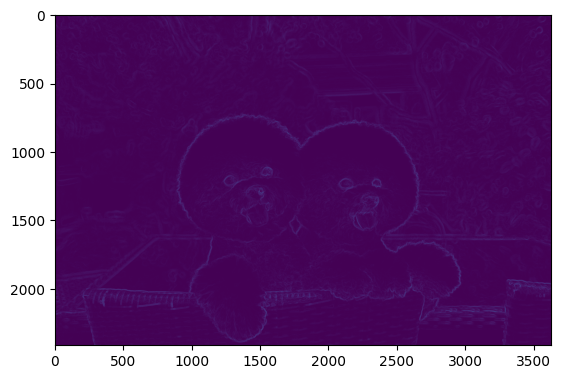

In [5]:
start = timer()
[horizontal, vertical, neutral] = sobel_filter_cpu(gim1)
end = timer()
print(f"Calculating Sobel Filter on CPU took: {round(end-start, 2)}s")
plt.imshow(neutral)

**CUDA Sobel Filter**

Calculating Sobel Filter on CPU took: 0.09s


/home/campbell/.local/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


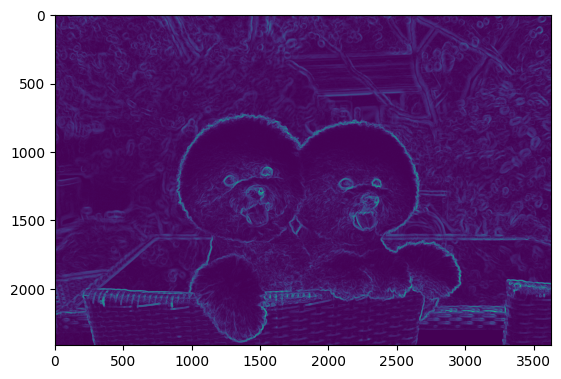

In [14]:
start = timer()
neutral = cuda_sobel(gim1)
end = timer()
print(f"Calculating Sobel Filter on CPU took: {round(end-start, 2)}s")
plt.imshow(neutral)